In [1]:
# Metrics and analysis
from sklearn.metrics import roc_auc_score, matthews_corrcoef,cohen_kappa_score, make_scorer
from sklearn.model_selection import learning_curve
# Data modelation
from sklearn.model_selection import cross_validate
# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
# Dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Pipeline
from sklearn.pipeline import make_pipeline
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r'archivos/creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
print(f"Existen {len(df[df['Class'] == 0])} transacciones legítimas.")
print(f"Existen {len(df[df['Class'] == 1])} transacciones fraudulentas.")

Existen 284315 transacciones legítimas.
Existen 492 transacciones fraudulentas.


In [4]:
def cutDatabase(df: pd.DataFrame, n: int= -1, random_seed: int=14):
    dfTrue = df[df['Class'] == 1]
    if n == -1:
        n = len(dfTrue)
    dfFalse = df[df['Class'] == 0].sampleb(n= n, random_state= random_seed) #se eligen 'n' filas al azar del nuevo data frame
    df_balanced = pd.concat([dfFalse, dfTrue]).sample(frac= 1).reset_index(drop= True)

    return df_balanced.drop(['Class'], axis=1).values, df_balanced['Class'].values

In [5]:
x_pass, y_pass = cutDatabase(df, 10000)

In [6]:
def plot_projection(x, y):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    plt.scatter(x[y == 1, 0],x[y == 1, 1])
    for i in range(len(np.unique(y))):
        plt.scatter(x[y == i, 0],x[y == i, 1])
    for i in range(np.unique(y)):
        xtext, ytext = np.median(x[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5,foreground="w"),PathEffects.Normal()])
    plt.show()

c:\Users\esepu\.conda\envs\ima539\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TypeError: only integer scalar arrays can be converted to a scalar index

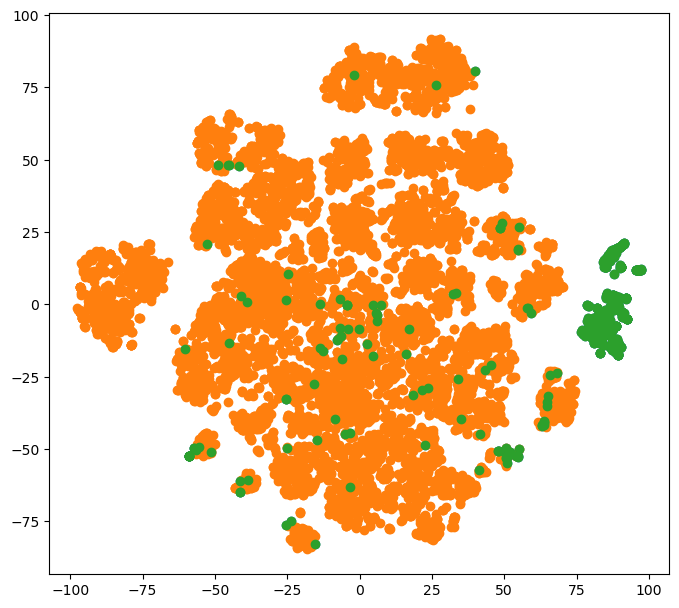

In [8]:
x_pass = StandardScaler().fit_transform(x_pass)
x_pass_tsne = TSNE(n_components= 2, init= 'pca', random_state= 16273, learning_rate= 'auto', n_jobs= -1).fit_transform(x_pass)
plot_projection(x_pass_tsne, y_pass)

In [8]:
randomForest = RandomForestClassifier(criterion= 'gini',n_estimators= 10, random_state= 1, n_jobs= -1)
modelPerceptron = make_pipeline(StandardScaler(),PCA(n_components=15),Perceptron(random_state=1))

In [9]:
scoring = {'accuracy' : 'balanced_accuracy',
           'precision': 'precision_weighted',
           'recall'   : 'recall_weighted',
           'f1'       : 'f1_weighted',
           'roc'      : make_scorer(roc_auc_score, average='weighted'),
           'mcc'      : make_scorer(matthews_corrcoef),
           'kappa'    : make_scorer(cohen_kappa_score)}

In [10]:
def printMetrics(model, scoring):
    for k in scoring.keys():
        print(f'CV {k}: \t{np.mean(model.get(f"test_{k}")):.3f} +/- {np.std(model.get(f"test_{k}")):.3f}')

In [11]:
x, y = df.drop(['Class'], axis=1).values, df['Class'].values

In [12]:
perceptronScores = cross_validate(modelPerceptron, x, y, scoring= scoring, cv=10, n_jobs= -1)
printMetrics(perceptronScores, scoring)

CV accuracy: 	0.804 +/- 0.078
CV precision: 	0.999 +/- 0.000
CV recall: 	0.999 +/- 0.001
CV f1: 	0.999 +/- 0.000
CV roc: 	0.804 +/- 0.078
CV mcc: 	0.635 +/- 0.111
CV kappa: 	0.613 +/- 0.117


In [13]:
rfScores = cross_validate(randomForest, x, y, scoring= scoring, cv=10, n_jobs= -1)
printMetrics(rfScores, scoring)

CV accuracy: 	0.807 +/- 0.122
CV precision: 	0.999 +/- 0.001
CV recall: 	0.903 +/- 0.288
CV f1: 	0.907 +/- 0.278
CV roc: 	0.807 +/- 0.122
CV mcc: 	0.713 +/- 0.258
CV kappa: 	0.700 +/- 0.257


In [17]:
x_balanced, y_balanced = cutDatabase(df)

In [18]:
x.shape, y.shape

((284807, 30), (284807,))

In [19]:
x_balanced.shape, y_balanced.shape

((984, 30), (984,))

In [23]:
scoring = {'accuracy' : 'accuracy',
           'precision': 'precision',
           'recall'   : 'recall',
           'f1'       : 'f1',
           'roc'      : 'roc_auc',
           'mcc'      : make_scorer(matthews_corrcoef),
           'kappa'    : make_scorer(cohen_kappa_score)}

In [47]:
modelPerceptron = make_pipeline(StandardScaler(),PCA(n_components=15),Perceptron(random_state=1))
perceptronScores = cross_validate(modelPerceptron, x_balanced, y_balanced, scoring= scoring, cv=10, n_jobs= -1)
printMetrics(perceptronScores, scoring)

CV accuracy: 	0.916 +/- 0.029
CV precision: 	0.920 +/- 0.052
CV recall: 	0.915 +/- 0.028
CV f1: 	0.916 +/- 0.026
CV roc: 	0.961 +/- 0.019
CV mcc: 	0.834 +/- 0.056
CV kappa: 	0.831 +/- 0.058


In [52]:
randomForest = RandomForestClassifier(criterion= 'gini',n_estimators= 10, random_state= 1, n_jobs= -1)
rfScores = cross_validate(modelPerceptron, x_balanced, y_balanced, scoring= scoring, cv=10, n_jobs= -1)
printMetrics(rfScores, scoring)

CV accuracy: 	0.923 +/- 0.020
CV precision: 	0.935 +/- 0.033
CV recall: 	0.911 +/- 0.030
CV f1: 	0.922 +/- 0.021
CV roc: 	0.960 +/- 0.019
CV mcc: 	0.847 +/- 0.040
CV kappa: 	0.845 +/- 0.040


**HACER CURVAS DE DESICION**